In [1]:
# Logistic Regression

In [2]:
# Bibliotheken laden
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay, make_scorer
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE

In [3]:
# Daten laden
X_train = pd.read_csv('X_train_imputiert_encoded.csv')
X_test = pd.read_csv('X_test_imputiert_encoded.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()  # .ravel(), falls y ein DataFrame mit 1 Spalte ist
y_test = pd.read_csv('y_test.csv').values.ravel()

In [4]:
# Evaluierungsfunktion
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name='Modell'):
    """
    Evaluiert ein Modell mit Trainings- und Testdaten.
    Gibt Accuracy, Precision, Recall, F1, ROC-AUC für beide Datensätze aus.
    Zeigt Confusion Matrix und ROC-Kurve für Testdaten.
    """
    # Vorhersagen
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Trainingsmetriken
    acc_train = accuracy_score(y_train, y_pred_train)
    prec_train = precision_score(y_train, y_pred_train, zero_division=0)
    rec_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    roc_auc_train = roc_auc_score(y_train, y_proba_train) if y_proba_train is not None else None

    # Testmetriken
    acc_test = accuracy_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test, zero_division=0)
    rec_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else None


    # Ausgabe
    print(f"\n**Bewertung für Modell: {model_name}**\n")
    print("Trainingsdaten:")
    print(f"  Accuracy     : {acc_train:.4f}")
    print(f"  Precision    : {prec_train:.4f}")
    print(f"  Recall       : {rec_train:.4f}")
    print(f"  F1-Score     : {f1_train:.4f}")
    print(f"  ROC-AUC      : {roc_auc_train:.4f}" if roc_auc_train is not None else "  ROC-AUC      : nicht verfügbar")

    print("\nTestdaten:")
    print(f"  Accuracy     : {acc_test:.4f}")
    print(f"  Precision    : {prec_test:.4f}")
    print(f"  Recall       : {rec_test:.4f}")
    print(f"  F1-Score     : {f1_test:.4f}")
    print(f"  ROC-AUC      : {roc_auc_test:.4f}" if roc_auc_test is not None else "  ROC-AUC      : nicht verfügbar")

    # Confusion Matrix (Test)
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC-Kurve (Test)
    if y_proba_test is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba_test, name=model_name)
        plt.title(f'ROC-Kurve: {model_name}')
        plt.grid(True)
        plt.show()

    # Rückgabe als Dictionary (für spätere Sammlung)
    return {
        'Model': model_name,
        'Train Accuracy': acc_train,
        'Train Precision': prec_train,
        'Train Recall': rec_train,
        'Train F1': f1_train,
        'Train ROC-AUC': roc_auc_train,
        'Test Accuracy': acc_test,
        'Test Precision': prec_test,
        'Test Recall': rec_test,
        'Test F1': f1_test,
        'Test ROC-AUC': roc_auc_test,
    }

In [5]:
# Hyperparametervergleich

# Scorer basierend auf dem "Overall Score" (Ø aus Recall + F1)
def custom_score(y_true, y_pred):
    return (recall_score(y_true, y_pred) + f1_score(y_true, y_pred)) / 2

scorer = make_scorer(custom_score)

# Pipeline mit Platzhaltern
pipe = ImbPipeline([
    ('scaler', StandardScaler()),         # Platzhalter
    ('smote', SMOTE(random_state=42)),    # Optional
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Parametergrid
param_grid = {
    'scaler': [None, StandardScaler(), MinMaxScaler()],
    'smote': [SMOTE(random_state=42), None],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__class_weight': [None, 'balanced'],
}

# GridSearchCV starten
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    verbose=0,
    n_jobs=-1,
    error_score='raise'
)

grid.fit(X_train, y_train)

# Ergebnisse in DataFrame umwandeln
import pandas as pd

results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Top 10 anzeigen
pd.set_option('display.max_colwidth', None)
print(results_df[['mean_test_score', 'params']].head(10))

    mean_test_score  \
17         0.919744   
15         0.874231   
4          0.854103   
16         0.854103   
21         0.823974   
14         0.819103   
2          0.819103   
22         0.814231   
10         0.814231   
46         0.813974   

                                                                                                                                  params  
17                      {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'scaler': MinMaxScaler(), 'smote': None}  
15                    {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'scaler': StandardScaler(), 'smote': None}  
4           {'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l1', 'scaler': MinMaxScaler(), 'smote': SMOTE(random_state=42)}  
16    {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'scaler': MinMaxScaler(), 'smote': SMOTE(random_state=42)}  
21                    {'clf__C': 0.01, 'clf__class_


**Bewertung für Modell: Beste LogReg (GridSearch)**

Trainingsdaten:
  Accuracy     : 0.6396
  Precision    : 0.1111
  Recall       : 0.9146
  F1-Score     : 0.1981
  ROC-AUC      : 0.8367

Testdaten:
  Accuracy     : 0.6409
  Precision    : 0.1067
  Recall       : 0.8600
  F1-Score     : 0.1898
  ROC-AUC      : 0.8321


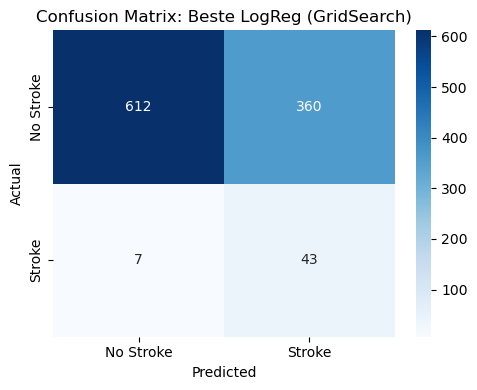

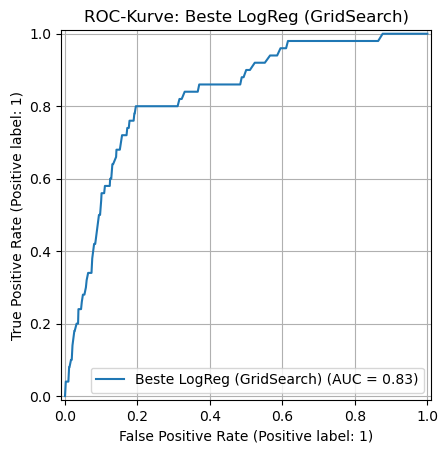

Beste Parameterkombination:
{'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'scaler': MinMaxScaler(), 'smote': None}


In [6]:
best_model = grid.best_estimator_
evaluate_model(best_model, X_train, y_train, X_test, y_test, model_name="Beste LogReg (GridSearch)")
print("Beste Parameterkombination:")
print(grid.best_params_)

In [7]:
# Koeffizienten und Odds Ratios
# Klassifikator aus pipeline extrahieren
logreg = best_model.named_steps['clf']

# Spaltennamen
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]

# Koeffizienten
coefficients = logreg.coef_[0]
odds_ratios = np.exp(coefficients)

# In DataFrame für Übersicht
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
}).sort_values(by='Odds Ratio', ascending=False)

display(coef_df)

,Feature,Coefficient,Odds Ratio
7,remainder__age,2.115361,8.292577
8,remainder__hypertension,0.102966,1.108454
0,encoder__work_type_Never_worked,0.000000,1.000000
1,encoder__work_type_Private,0.000000,1.000000
2,encoder__work_type_Self-employed,0.000000,1.000000
3,encoder__work_type_children,0.000000,1.000000
5,encoder__smoking_status_smokes,0.000000,1.000000
6,remainder__gender,0.000000,1.000000
9,remainder__heart_disease,0.000000,1.000000
10,remainder__ever_married,0.000000,1.000000


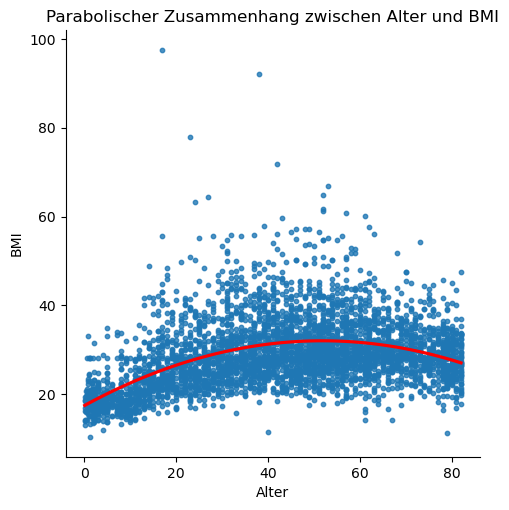

In [8]:
# Polynominal Features

# Parabolischer Fit (2. Ordnung)
sns.lmplot(data=X_train, x='remainder__age', y='remainder__bmi', order=2, scatter_kws={'s': 10}, line_kws={'color': 'red'})

plt.title("Parabolischer Zusammenhang zwischen Alter und BMI")
plt.xlabel("Alter")
plt.ylabel("BMI")
plt.show()


**Bewertung für Modell: LogReg mit quadratischen Features**

Trainingsdaten:
  Accuracy     : 0.7240
  Precision    : 0.1311
  Recall       : 0.8291
  F1-Score     : 0.2263
  ROC-AUC      : 0.8451

Testdaten:
  Accuracy     : 0.7084
  Precision    : 0.1242
  Recall       : 0.8200
  F1-Score     : 0.2158
  ROC-AUC      : 0.8373


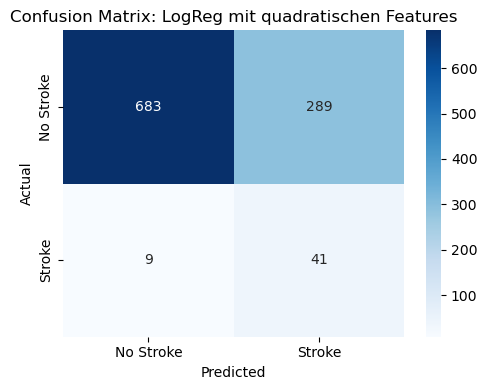

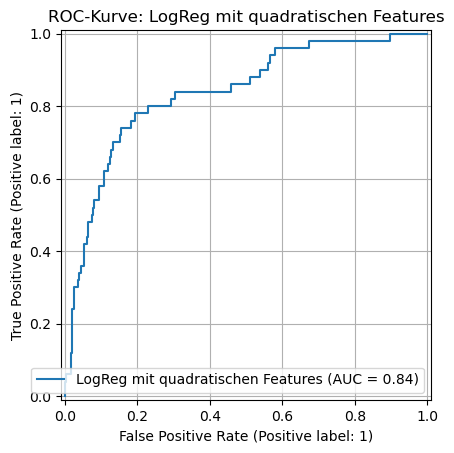

{'Model': 'LogReg mit quadratischen Features',
 'Train Accuracy': 0.7240029361389773,
 'Train Precision': 0.13105639396346305,
 'Train Recall': 0.8291457286432161,
 'Train F1': 0.22633744855967078,
 'Train ROC-AUC': 0.845140052112414,
 'Test Accuracy': 0.7084148727984344,
 'Test Precision': 0.12424242424242424,
 'Test Recall': 0.82,
 'Test F1': 0.21578947368421053,
 'Test ROC-AUC': 0.8373045267489712}

In [9]:
def add_poly_features_df(X):
    X = X.copy()
    X['age_squared'] = X['remainder__age'] ** 2
    X['bmi_squared'] = X['remainder__bmi'] ** 2
    return X
    
poly_transformer = FunctionTransformer(add_poly_features_df, validate=False)

best_model = Pipeline([
    ('poly', poly_transformer),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l1',
        C=0.01,
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000
    ))
])

best_model.fit(X_train, y_train)
evaluate_model(best_model, X_train, y_train, X_test, y_test, model_name='LogReg mit quadratischen Features')